# Model training

For this demo we'll use the freely available Statlog (German Credit Data) Data Set, which can be downloaded from [Kaggle](https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)). This dataset classifies customers based on a set of attributes into two credit risk groups - good or bad. The majority of the attributes in this data set are categorical, and they are symbolically encoded. For example, attribute 1 represents the status of an existing checking account and can take one of the following values:

A11 : ... < 0 DM

A12 : 0 <= ... < 200 DM

A13 : ... >= 200 DM / salary assignments for at least 1 year

A14 : no checking account

A comprehensive list of all attributes and symbol codes is given in the [document](https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.doc) that accompanies the original dataset. 

The data we use in this demo has also been balanced and upsampled (see the [Data Generation](./data_generation.ipynb) notebook for reference).

## Seting up and connecting to Ray


Let's start by loading all the libraries needed for the notebook and by setting up default data paths.


In [1]:
import os
import ray
import glob
import eli5

import xgboost_ray as xgbr
import xgboost as xgb
import pandas as pd

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from ray import tune

DATA_ROOT = os.path.join("/mnt/data", os.environ["DOMINO_PROJECT_NAME"], "data") 
MODEL_ROOT = "/mnt/artifacts"
TUNE_ROOT = os.path.join("/mnt/data", os.environ["DOMINO_PROJECT_NAME"], "ray_results")

In this demo we'll use a dataset of a modest size (approx. 700 MB). Unfortunately, the standard Python libraries for data processing and machine learning Pandas and NumPy have never been designed with large datasets in mind. They rely on being able to fit the entire data in-memory with Pandas data frames having a hard theoretical limit of 100GB. In practice, the amount of data these libraries can handle is also restricted by the amount of physical memory available to the container that runs them, thus they'll have challenges handling even the 700 MB needed for our demo dataset. Trying to load our training data into a simple Pandas data frame using the code below will likely crash the Jupyter kernel.

``` 
# Do not run this code - it will likely crash the Jupyter kernel 
# (depending on the HW tier running the kernel)

import pandas as pd
import glob
import os

all_files = glob.glob(DATA_ROOT + "/train_data_*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

training_df = pd.concat(li, axis=0, ignore_index=True)
training_df.head()
```

To circumvent these restrictions Domino provides support for a number of industry-standard distributed computing frameworks like Ray, Dask, and Spark. In this demo we will use [On-Demand Ray](https://docs.dominodatalab.com/en/latest/user_guide/d13903/on-demand-ray-overview/). 

Ray is a general framework that enables you to quickly parallelize existing Python code, but it is also talked about as a "framework for building frameworks". Indeed, there are a growing number of domain-specific libraries that work on top of Ray.

![Ray](./images/ray.png)

For example:

* RaySGD - a library for distributed deep learning, which provides wrappers around PyTorch and TensorFlow
* RLlib - a library for reinforcement learning, which also natively supports TensorFlow, TensorFlow Eager, and PyTorch
* RayServe - a scalable, model-serving library
* Ray Tune - a hyperparameter optimization framework, most commonly used for deep and reinforcement learning

In this demo we'll use [Ray Tune](https://docs.ray.io/en/latest/tune/index.html) for hyperparameter optimisation and [XGBoost on Ray](https://github.com/ray-project/xgboost_ray) for model training.

In [2]:
# We'll set up Ray for 2 workers, 4 CPUs each (12 CPUs in total, counting the head node).

RAY_ACTORS = 3
RAY_CPUS_PER_ACTOR = 4

Let's connect to Ray.

In [3]:
if ray.is_initialized() == False:
    service_host = os.environ["RAY_HEAD_SERVICE_HOST"]
    service_port = os.environ["RAY_HEAD_SERVICE_PORT"]
    ray.init(f"ray://{service_host}:{service_port}")

Let's confirm we have the expected cluster configuration.

In [4]:
ray.nodes()

[{'NodeID': '485fbd09ebfd9a4b788e649ecf80e6a7bd43bf856b56ee47a94845c2',
  'Alive': True,
  'NodeManagerAddress': '100.64.46.131',
  'NodeManagerHostname': 'ray-687e6c2cf9ac5a56add949fa-ray-worker-2',
  'NodeManagerPort': 2385,
  'ObjectManagerPort': 2384,
  'ObjectStoreSocketName': '/tmp/ray/session_2025-07-21_09-35-11_247340_1/sockets/plasma_store',
  'RayletSocketName': '/tmp/ray/session_2025-07-21_09-35-11_247340_1/sockets/raylet',
  'MetricsExportPort': 50925,
  'NodeName': '100.64.46.131',
  'alive': True,
  'Resources': {'object_store_memory': 4766361600.0,
   'node:100.64.46.131': 1.0,
   'CPU': 4.0,
   'memory': 11121510400.0}},
 {'NodeID': '9457e4c73e6f097dbd84e3d8211445f2fbe304db684fc55cb2f869a5',
  'Alive': True,
  'NodeManagerAddress': '100.64.87.68',
  'NodeManagerHostname': 'ray-687e6c2cf9ac5a56add949fa-ray-worker-1',
  'NodeManagerPort': 2385,
  'ObjectManagerPort': 2384,
  'ObjectStoreSocketName': '/tmp/ray/session_2025-07-21_09-35-11_247340_1/sockets/plasma_store',
  '

Now let's create a list of all the shards for our training, validation, and test sets.

In [5]:
train_files = glob.glob(os.path.join(DATA_ROOT, "train_data*"))
val_files = glob.glob(os.path.join(DATA_ROOT, "validation_data*"))

test_file = os.path.join(DATA_ROOT, "test_data.csv")

target_col = "credit"

XGBoost-Ray provides a drop-in replacement for XGBoost's train function. To pass data, instead of using xgb.DMatrix we will have to use xgboost_ray.RayDMatrix. The RayDMatrix lazy loads data and stores it sharded in the Ray object store. The Ray XGBoost actors then access these shards to run their training on. Let's wrap our training, validation, and test sets into RayDMatrix objects.

In [6]:
# Although it is possible to specify the number of Actors when initializing the RayDMatrix, it is not necessary,
#  and can cause a conflict if different from the number of Actors chosen for training.

rdm_train = xgbr.RayDMatrix(train_files, label=target_col)
rdm_val = xgbr.RayDMatrix(val_files, label=target_col)

df_test = pd.read_csv(test_file)
rdm_test = xgbr.RayDMatrix(df_test, label=target_col)

In [7]:
# This function verifies whether the data will support splitting into a given number of shards.
# We use this to validate that our splits are compatible with the selected Ray cluster configuraiton (i.e. number of Ray nodes)

rdm_train.assert_enough_shards_for_actors(len(train_files))
rdm_train.assert_enough_shards_for_actors(len(val_files))

In [8]:
print("Will the read be distributed?", rdm_train.distributed)
print("Has any data been read yet?", rdm_train.loaded) # Remember, lazy loading

Will the read be distributed? True
Has any data been read yet? False


## Model training

Let's first try to train a single model in order to validate our setup. Feel free to switch to the Ray Web UI tab and observe the distribution of workload among the individual Ray nodes.

A few things to note:

* We are using “binary:logistic” – logistic regression for binary classification (*credit* is in {0,1}), which outputs probability
* We are calculating both logloss and error as evaluation metrics. They don't impact the model fitting
* We are passing the cluster topology via the xgb_ray_params objects so that the workload can be correctly distributed


In [9]:
# Set a few hyperparameters to specific values
param = {
    "seed":1234,
    "max_depth":3,
    "eta":0.1,
    "objective": "binary:logistic",
    "eval_metric": ["logloss", "error"]
}

xgb_ray_params = xgbr.RayParams(
    num_actors=RAY_ACTORS,
    cpus_per_actor=RAY_CPUS_PER_ACTOR
)

# Train the model
evals_result = {}

bst = xgbr.train(
    param,
    rdm_train,
    num_boost_round=50,
    verbose_eval=True,
    evals_result=evals_result,
    evals =[(rdm_train, "train"), (rdm_val, "val")],
    ray_params=xgb_ray_params
)

print("Final training error: {:.4f}".format(evals_result["train"]["error"][-1]))
print("Final validation error: {:.4f}".format(evals_result["val"]["error"][-1]))

/opt/conda/lib/python3.9/site-packages/xgboost_ray/util.py:89: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
Use get_node_id() instead
  current_node_id = ray.get_runtime_context().node_id.hex()
(_wrapped pid=454) 2025-07-21 09:40:09,433	INFO main.py:1047 -- [RayXGBoost] Created 3 new actors (3 total actors). Waiting until actors are ready for training.
(_wrapped pid=454) 2025-07-21 09:40:23,135	INFO main.py:1092 -- [RayXGBoost] Starting XGBoost training.
(_RemoteRayXGBoostActor pid=172, ip=100.64.46.131) [09:40:23] task [xgboost.ray]:126077903668848 got new rank 0
(_RemoteRayXGBoostActor pid=211, ip=100.64.79.49) [09:40:23] task [xgboost.ray]:125863567622976 got new rank 1
(_RemoteRayXGBoostActor pid=171, ip=100.64.87.68) [09:40:23] task [xgboost.ray]:125485607400784 got new rank 2


(_wrapped pid=454) [0]	train-logloss:0.65890	train-error:0.22747	val-logloss:0.65631	val-error:0.20883
(_wrapped pid=454) [1]	train-logloss:0.63105	train-error:0.22322	val-logloss:0.62528	val-error:0.20100
(_wrapped pid=454) [2]	train-logloss:0.60865	train-error:0.22340	val-logloss:0.60093	val-error:0.21037
(_wrapped pid=454) [3]	train-logloss:0.58683	train-error:0.20024	val-logloss:0.57770	val-error:0.17753
(_wrapped pid=454) [4]	train-logloss:0.56887	train-error:0.19834	val-logloss:0.55733	val-error:0.17213
(_wrapped pid=454) [5]	train-logloss:0.55296	train-error:0.18635	val-logloss:0.54088	val-error:0.16274
(_wrapped pid=454) [6]	train-logloss:0.53873	train-error:0.18173	val-logloss:0.52620	val-error:0.15723
(_wrapped pid=454) [7]	train-logloss:0.52442	train-error:0.17974	val-logloss:0.51060	val-error:0.16108
(_wrapped pid=454) [8]	train-logloss:0.51177	train-error:0.17802	val-logloss:0.49672	val-error:0.16424
(_wrapped pid=454) [9]	train-logloss:0.50048	train-error:0.16876	val-logl

(_wrapped pid=454) 2025-07-21 09:40:53,649	INFO main.py:1175 -- Training in progress (31 seconds since last restart).


(_wrapped pid=454) [33]	train-logloss:0.34910	train-error:0.12610	val-logloss:0.33604	val-error:0.11894
(_wrapped pid=454) [34]	train-logloss:0.34563	train-error:0.12341	val-logloss:0.33241	val-error:0.11427
(_wrapped pid=454) [35]	train-logloss:0.34209	train-error:0.12078	val-logloss:0.32824	val-error:0.10792
(_wrapped pid=454) [36]	train-logloss:0.33887	train-error:0.11931	val-logloss:0.32486	val-error:0.10715
(_wrapped pid=454) [37]	train-logloss:0.33525	train-error:0.12169	val-logloss:0.32043	val-error:0.10795
(_wrapped pid=454) [38]	train-logloss:0.33301	train-error:0.11706	val-logloss:0.31812	val-error:0.10324
(_wrapped pid=454) [39]	train-logloss:0.32948	train-error:0.11211	val-logloss:0.31456	val-error:0.09856
(_wrapped pid=454) [40]	train-logloss:0.32674	train-error:0.11108	val-logloss:0.31153	val-error:0.09692
(_wrapped pid=454) [41]	train-logloss:0.32437	train-error:0.10827	val-logloss:0.30940	val-error:0.09539
(_wrapped pid=454) [42]	train-logloss:0.32163	train-error:0.1073

(_wrapped pid=454) 2025-07-21 09:41:06,691	INFO main.py:1587 -- [RayXGBoost] Finished XGBoost training on training data with total N=2,100,000 in 58.30 seconds (43.55 pure XGBoost training time).


Final training error: 0.1003
Final validation error: 0.0876


Now that we've confirmed the pipeline we can move onto performing some hyperparameter tuning for finding an optimal model.

## Hyperparameter tuning

Hyperparameter tuning requires training many copies of a model, each with a different set of hyperparameters, and seeing which one performs the best. Each time we train a model, that is one trial. To do this in our Ray cluster, we can specify what resources to use:

* Required CPU, Memory, and/or GPU per trial
* Where to store intermediate results

The `xgboost_ray` library includes a built-in method for generating a `PlacementGroupFactory` to pass to Ray Tune, based on the `RayParams` object used for XGBoost training. Resources can also be requested in a simpler dictionary format, e.g. `{"cpu": 2.0}`. As described in the [Tune docs](https://docs.ray.io/en/latest/tune/tutorials/tune-resources.html), by default Ray Tune will schedule N concurrent trials, using 1 CPU per trial, where N is the total number of CPUs available in the cluster.

In [10]:
# Get the placement group factory to pass to Ray Tune
# Notice how the tune resources are 1 CPU greater!
xgb_tune_resources = xgb_ray_params.get_tune_resources()
print(f"We will pass a {type(xgb_tune_resources)} to Ray Tune.")
print(f"It will request {xgb_tune_resources.required_resources} per trial.")
print(f"The cluster has {ray.cluster_resources()['CPU']} CPU total.")

We will pass a <class 'ray.tune.execution.placement_groups.PlacementGroupFactory'> to Ray Tune.
It will request {'CPU': 12.0} per trial.
The cluster has 12.0 CPU total.


In [11]:
print("Saving intermediate tune results to", TUNE_ROOT)

Saving intermediate tune results to /mnt/data/Credit-Risk-Model/ray_results


In this demo we will use a very simple search strategy called *a grid search*. This involves searching over a predefined grid of hyperparameter choices - and it's easy to imaging writing a simple for loop to implement it. However, for $n$ choices each of $k$ hyperparameters, a full grid search requires $O(n^k)$ trials and quickly becomes prohibitively expensive.

Ray Tune provides much more sophisticated options for optimization. Instead of pre-defining a fixed grid to search over, Ray Tune allows specifying a [search space](https://docs.ray.io/en/releases-1.11.0/tune/key-concepts.html#search-spaces) with distributions of parameters. The number of trials over the search space is specified at a later stage in the `run()` function.

In [12]:
config = {
    "seed": 1234,
    "eta": tune.loguniform(3e-3, 3e-1),
    "max_depth": tune.randint(2, 6),
    "objective": "binary:logistic",
    "eval_metric": ["logloss", "error"]
}

For each trial, a config dictionary like the one we just defined, with the single value for each hyperparameter chosen for that trial, will be passed into a [trainable](https://docs.ray.io/en/releases-1.11.0/tune/key-concepts.html#search-algorithms) that we define and pass to Ray Tune. Below we have defined such a function to wrap training a single XGBoost model on Ray.

In [13]:
def my_trainer(config):
    evals_result = {}
    bst = xgbr.train(
        params=config,
        dtrain=rdm_train,
        num_boost_round=50,
        evals_result=evals_result,
        evals=[(rdm_train, "train"), (rdm_val, "val")],
        ray_params=xgb_ray_params
    )
    bst.save_model("model.xgb") # This will go into the TUNE_ROOT directory

Finally, we can now run our trials. Here we bring together the previous few sections:

* The training function
* The search space defined in the config
* The resources per trial and results location

We control the number of trials over the search space via the `num_samples` argument (currently set to 10). We also rank the models based on the lowest validation set error.

In [14]:
analysis = tune.run(
    my_trainer,
    config=config,
    resources_per_trial=xgb_tune_resources,
    local_dir=TUNE_ROOT,
    metric="val-error",
    mode="min",
    num_samples=10,
    verbose=1,
    progress_reporter=tune.JupyterNotebookReporter(overwrite=True)
)

(run pid=454) UserWarning: The `local_dir` argument of `Experiment is deprecated. Use `storage_path` or set the `TUNE_RESULT_DIR` environment variable instead.
(_RemoteRayXGBoostActor pid=254, ip=100.64.46.131) [09:41:18] task [xgboost.ray]:123563154747552 got new rank 0
(_RemoteRayXGBoostActor pid=296, ip=100.64.79.49) [09:41:18] task [xgboost.ray]:131406277650320 got new rank 1
(_RemoteRayXGBoostActor pid=253, ip=100.64.87.68) [09:41:18] task [xgboost.ray]:126433008333632 got new rank 2


(my_trainer pid=804) [0]	train-logloss:0.68427	train-error:0.22747	val-logloss:0.68362	val-error:0.20883
(my_trainer pid=804) [1]	train-logloss:0.67613	train-error:0.22331	val-logloss:0.67457	val-error:0.20021
(my_trainer pid=804) [2]	train-logloss:0.66801	train-error:0.22331	val-logloss:0.66582	val-error:0.20021
(my_trainer pid=804) [3]	train-logloss:0.66056	train-error:0.22331	val-logloss:0.65751	val-error:0.20021
(my_trainer pid=804) [4]	train-logloss:0.65345	train-error:0.21114	val-logloss:0.64949	val-error:0.18773
(my_trainer pid=804) [5]	train-logloss:0.64625	train-error:0.22331	val-logloss:0.64173	val-error:0.20021
(my_trainer pid=804) [6]	train-logloss:0.63970	train-error:0.21686	val-logloss:0.63443	val-error:0.19396
(my_trainer pid=804) [7]	train-logloss:0.63361	train-error:0.21620	val-logloss:0.62784	val-error:0.19941
(my_trainer pid=804) [8]	train-logloss:0.62758	train-error:0.21047	val-logloss:0.62104	val-error:0.19396
(my_trainer pid=804) [9]	train-logloss:0.62198	train-er

(my_trainer pid=804) 2025-07-21 09:41:49,291	INFO main.py:1175 -- Training in progress (31 seconds since last restart).


(my_trainer pid=804) [33]	train-logloss:0.52175	train-error:0.17649	val-logloss:0.50809	val-error:0.15880
(my_trainer pid=804) [34]	train-logloss:0.51865	train-error:0.17977	val-logloss:0.50480	val-error:0.16116
(my_trainer pid=804) [35]	train-logloss:0.51575	train-error:0.17368	val-logloss:0.50178	val-error:0.15487
(my_trainer pid=804) [36]	train-logloss:0.51288	train-error:0.17424	val-logloss:0.49906	val-error:0.15491
(my_trainer pid=804) [37]	train-logloss:0.51019	train-error:0.17403	val-logloss:0.49622	val-error:0.15490
(my_trainer pid=804) [38]	train-logloss:0.50746	train-error:0.17231	val-logloss:0.49349	val-error:0.15415
(my_trainer pid=804) [39]	train-logloss:0.50464	train-error:0.16861	val-logloss:0.49068	val-error:0.15025
(my_trainer pid=804) [40]	train-logloss:0.50199	train-error:0.17030	val-logloss:0.48793	val-error:0.15183
(my_trainer pid=804) [41]	train-logloss:0.49914	train-error:0.16828	val-logloss:0.48533	val-error:0.15023
(my_trainer pid=804) [42]	train-logloss:0.4967

(_RemoteRayXGBoostActor pid=416, ip=100.64.46.131) [09:42:08] task [xgboost.ray]:129818011711232 got new rank 0
(_RemoteRayXGBoostActor pid=379, ip=100.64.79.49) [09:42:08] task [xgboost.ray]:132320922729344 got new rank 1
(_RemoteRayXGBoostActor pid=336, ip=100.64.87.68) [09:42:08] task [xgboost.ray]:136788552828672 got new rank 2


(my_trainer pid=804) [0]	train-logloss:0.68970	train-error:0.20367	val-logloss:0.68957	val-error:0.19787
(my_trainer pid=804) [1]	train-logloss:0.68631	train-error:0.20367	val-logloss:0.68604	val-error:0.19787
(my_trainer pid=804) [2]	train-logloss:0.68297	train-error:0.20367	val-logloss:0.68255	val-error:0.19787
(my_trainer pid=804) [3]	train-logloss:0.67968	train-error:0.20367	val-logloss:0.67913	val-error:0.19787
(my_trainer pid=804) [4]	train-logloss:0.67650	train-error:0.19304	val-logloss:0.67568	val-error:0.18065
(my_trainer pid=804) [5]	train-logloss:0.67331	train-error:0.19304	val-logloss:0.67236	val-error:0.18065
(my_trainer pid=804) [6]	train-logloss:0.67022	train-error:0.19304	val-logloss:0.66903	val-error:0.18065
(my_trainer pid=804) [7]	train-logloss:0.66722	train-error:0.19316	val-logloss:0.66572	val-error:0.18142
(my_trainer pid=804) [8]	train-logloss:0.66422	train-error:0.19508	val-logloss:0.66248	val-error:0.18378
(my_trainer pid=804) [9]	train-logloss:0.66126	train-er

(my_trainer pid=804) 2025-07-21 09:42:39,440	INFO main.py:1175 -- Training in progress (31 seconds since last restart).


(my_trainer pid=804) [32]	train-logloss:0.60238	train-error:0.17859	val-logloss:0.59619	val-error:0.16048
(my_trainer pid=804) [33]	train-logloss:0.60022	train-error:0.18026	val-logloss:0.59378	val-error:0.16283
(my_trainer pid=804) [34]	train-logloss:0.59794	train-error:0.17880	val-logloss:0.59132	val-error:0.16127
(my_trainer pid=804) [35]	train-logloss:0.59576	train-error:0.17880	val-logloss:0.58895	val-error:0.16127
(my_trainer pid=804) [36]	train-logloss:0.59361	train-error:0.17768	val-logloss:0.58666	val-error:0.15969
(my_trainer pid=804) [37]	train-logloss:0.59155	train-error:0.17758	val-logloss:0.58436	val-error:0.15738
(my_trainer pid=804) [38]	train-logloss:0.58945	train-error:0.17790	val-logloss:0.58205	val-error:0.15972
(my_trainer pid=804) [39]	train-logloss:0.58737	train-error:0.17540	val-logloss:0.57989	val-error:0.16204
(my_trainer pid=804) [40]	train-logloss:0.58536	train-error:0.17905	val-logloss:0.57763	val-error:0.15971
(my_trainer pid=804) [41]	train-logloss:0.5833

(_RemoteRayXGBoostActor pid=537, ip=100.64.46.131) [09:42:59] task [xgboost.ray]:134847651927952 got new rank 0
(_RemoteRayXGBoostActor pid=464, ip=100.64.79.49) [09:42:59] task [xgboost.ray]:137342820198336 got new rank 1
(_RemoteRayXGBoostActor pid=458, ip=100.64.87.68) [09:42:59] task [xgboost.ray]:139753985107568 got new rank 2


(my_trainer pid=804) [0]	train-logloss:0.68511	train-error:0.30285	val-logloss:0.68465	val-error:0.29079
(my_trainer pid=804) [1]	train-logloss:0.67754	train-error:0.26686	val-logloss:0.67651	val-error:0.24841
(my_trainer pid=804) [2]	train-logloss:0.67040	train-error:0.26686	val-logloss:0.66894	val-error:0.24841
(my_trainer pid=804) [3]	train-logloss:0.66366	train-error:0.26686	val-logloss:0.66168	val-error:0.24841
(my_trainer pid=804) [4]	train-logloss:0.65730	train-error:0.26686	val-logloss:0.65491	val-error:0.24841
(my_trainer pid=804) [5]	train-logloss:0.65128	train-error:0.27810	val-logloss:0.64835	val-error:0.26415
(my_trainer pid=804) [6]	train-logloss:0.64554	train-error:0.27810	val-logloss:0.64227	val-error:0.26415
(my_trainer pid=804) [7]	train-logloss:0.64012	train-error:0.27810	val-logloss:0.63647	val-error:0.26415
(my_trainer pid=804) [8]	train-logloss:0.63461	train-error:0.26502	val-logloss:0.63059	val-error:0.24606
(my_trainer pid=804) [9]	train-logloss:0.62957	train-er

(my_trainer pid=804) 2025-07-21 09:43:30,076	INFO main.py:1175 -- Training in progress (31 seconds since last restart).


(my_trainer pid=804) [33]	train-logloss:0.54376	train-error:0.21384	val-logloss:0.53618	val-error:0.20006
(my_trainer pid=804) [34]	train-logloss:0.54133	train-error:0.22477	val-logloss:0.53392	val-error:0.21177
(my_trainer pid=804) [35]	train-logloss:0.53861	train-error:0.21362	val-logloss:0.53106	val-error:0.19927
(my_trainer pid=804) [36]	train-logloss:0.53615	train-error:0.22320	val-logloss:0.52838	val-error:0.20943
(my_trainer pid=804) [37]	train-logloss:0.53361	train-error:0.21162	val-logloss:0.52576	val-error:0.19768
(my_trainer pid=804) [38]	train-logloss:0.53130	train-error:0.21038	val-logloss:0.52343	val-error:0.19534
(my_trainer pid=804) [39]	train-logloss:0.52912	train-error:0.21071	val-logloss:0.52120	val-error:0.19607
(my_trainer pid=804) [40]	train-logloss:0.52685	train-error:0.21194	val-logloss:0.51882	val-error:0.19769
(my_trainer pid=804) [41]	train-logloss:0.52435	train-error:0.20722	val-logloss:0.51620	val-error:0.19300
(my_trainer pid=804) [42]	train-logloss:0.5222

(_RemoteRayXGBoostActor pid=656, ip=100.64.46.131) [09:43:48] task [xgboost.ray]:136581514063936 got new rank 0
(_RemoteRayXGBoostActor pid=551, ip=100.64.79.49) [09:43:48] task [xgboost.ray]:130773740017408 got new rank 1
(_RemoteRayXGBoostActor pid=540, ip=100.64.87.68) [09:43:49] task [xgboost.ray]:127774511695760 got new rank 2


(my_trainer pid=804) [0]	train-logloss:0.68541	train-error:0.16109	val-logloss:0.68531	val-error:0.15954
(my_trainer pid=804) [1]	train-logloss:0.67789	train-error:0.16109	val-logloss:0.67777	val-error:0.15954
(my_trainer pid=804) [2]	train-logloss:0.67063	train-error:0.15846	val-logloss:0.67038	val-error:0.15730
(my_trainer pid=804) [3]	train-logloss:0.66354	train-error:0.15846	val-logloss:0.66314	val-error:0.15730
(my_trainer pid=804) [4]	train-logloss:0.65678	train-error:0.16073	val-logloss:0.65588	val-error:0.15960
(my_trainer pid=804) [5]	train-logloss:0.65018	train-error:0.15635	val-logloss:0.64874	val-error:0.15176
(my_trainer pid=804) [6]	train-logloss:0.64354	train-error:0.15783	val-logloss:0.64200	val-error:0.15418
(my_trainer pid=804) [7]	train-logloss:0.63722	train-error:0.15298	val-logloss:0.63530	val-error:0.14397
(my_trainer pid=804) [8]	train-logloss:0.63103	train-error:0.14221	val-logloss:0.62863	val-error:0.13072
(my_trainer pid=804) [9]	train-logloss:0.62507	train-er

(my_trainer pid=804) 2025-07-21 09:44:19,585	INFO main.py:1175 -- Training in progress (31 seconds since last restart).


(my_trainer pid=804) [32]	train-logloss:0.51558	train-error:0.12543	val-logloss:0.50646	val-error:0.11203
(my_trainer pid=804) [33]	train-logloss:0.51170	train-error:0.12622	val-logloss:0.50244	val-error:0.11359
(my_trainer pid=804) [34]	train-logloss:0.50817	train-error:0.12658	val-logloss:0.49853	val-error:0.11358
(my_trainer pid=804) [35]	train-logloss:0.50458	train-error:0.12476	val-logloss:0.49477	val-error:0.11123
(my_trainer pid=804) [36]	train-logloss:0.50106	train-error:0.12293	val-logloss:0.49105	val-error:0.10886
(my_trainer pid=804) [37]	train-logloss:0.49759	train-error:0.12282	val-logloss:0.48726	val-error:0.10964
(my_trainer pid=804) [38]	train-logloss:0.49385	train-error:0.12271	val-logloss:0.48340	val-error:0.10886
(my_trainer pid=804) [39]	train-logloss:0.49020	train-error:0.12328	val-logloss:0.47952	val-error:0.10884
(my_trainer pid=804) [40]	train-logloss:0.48644	train-error:0.12147	val-logloss:0.47570	val-error:0.10728
(my_trainer pid=804) [41]	train-logloss:0.4829

(_RemoteRayXGBoostActor pid=736, ip=100.64.46.131) [09:44:40] task [xgboost.ray]:134589743237968 got new rank 0
(_RemoteRayXGBoostActor pid=716, ip=100.64.79.49) [09:44:40] task [xgboost.ray]:135695982052688 got new rank 1
(_RemoteRayXGBoostActor pid=623, ip=100.64.87.68) [09:44:40] task [xgboost.ray]:132497123494784 got new rank 2


(my_trainer pid=804) [0]	train-logloss:0.59673	train-error:0.16109	val-logloss:0.59546	val-error:0.15954
(my_trainer pid=804) [1]	train-logloss:0.52990	train-error:0.14702	val-logloss:0.52267	val-error:0.13459
(my_trainer pid=804) [2]	train-logloss:0.47927	train-error:0.12762	val-logloss:0.46893	val-error:0.11744
(my_trainer pid=804) [3]	train-logloss:0.43513	train-error:0.11403	val-logloss:0.42419	val-error:0.10172
(my_trainer pid=804) [4]	train-logloss:0.40061	train-error:0.10316	val-logloss:0.38791	val-error:0.08767
(my_trainer pid=804) [5]	train-logloss:0.37386	train-error:0.09305	val-logloss:0.36084	val-error:0.08221
(my_trainer pid=804) [6]	train-logloss:0.34787	train-error:0.08809	val-logloss:0.33561	val-error:0.07678
(my_trainer pid=804) [7]	train-logloss:0.32409	train-error:0.08614	val-logloss:0.31346	val-error:0.07753
(my_trainer pid=804) [8]	train-logloss:0.30345	train-error:0.07812	val-logloss:0.29339	val-error:0.07439
(my_trainer pid=804) [9]	train-logloss:0.28677	train-er

(my_trainer pid=804) 2025-07-21 09:45:11,209	INFO main.py:1175 -- Training in progress (31 seconds since last restart).


(my_trainer pid=804) [32]	train-logloss:0.12330	train-error:0.01438	val-logloss:0.11487	val-error:0.01097
(my_trainer pid=804) [33]	train-logloss:0.11995	train-error:0.01584	val-logloss:0.11164	val-error:0.01332
(my_trainer pid=804) [34]	train-logloss:0.11352	train-error:0.01131	val-logloss:0.10634	val-error:0.01019
(my_trainer pid=804) [35]	train-logloss:0.11182	train-error:0.01085	val-logloss:0.10484	val-error:0.01019
(my_trainer pid=804) [36]	train-logloss:0.10962	train-error:0.01166	val-logloss:0.10286	val-error:0.01100
(my_trainer pid=804) [37]	train-logloss:0.10836	train-error:0.01166	val-logloss:0.10163	val-error:0.01100
(my_trainer pid=804) [38]	train-logloss:0.10557	train-error:0.00962	val-logloss:0.09865	val-error:0.00786
(my_trainer pid=804) [39]	train-logloss:0.10456	train-error:0.00962	val-logloss:0.09764	val-error:0.00786
(my_trainer pid=804) [40]	train-logloss:0.10289	train-error:0.01008	val-logloss:0.09609	val-error:0.00786
(my_trainer pid=804) [41]	train-logloss:0.1006

(_RemoteRayXGBoostActor pid=817, ip=100.64.46.131) [09:45:32] task [xgboost.ray]:133351394346416 got new rank 0
(_RemoteRayXGBoostActor pid=841, ip=100.64.79.49) [09:45:32] task [xgboost.ray]:139748257035984 got new rank 1
(_RemoteRayXGBoostActor pid=745, ip=100.64.87.68) [09:45:32] task [xgboost.ray]:131235448485632 got new rank 2


(my_trainer pid=804) [0]	train-logloss:0.64435	train-error:0.16109	val-logloss:0.64371	val-error:0.15954
(my_trainer pid=804) [1]	train-logloss:0.60390	train-error:0.14654	val-logloss:0.60050	val-error:0.13700
(my_trainer pid=804) [2]	train-logloss:0.56966	train-error:0.14396	val-logloss:0.56517	val-error:0.13540
(my_trainer pid=804) [3]	train-logloss:0.53849	train-error:0.14283	val-logloss:0.53258	val-error:0.13540
(my_trainer pid=804) [4]	train-logloss:0.51147	train-error:0.12752	val-logloss:0.50325	val-error:0.11668
(my_trainer pid=804) [5]	train-logloss:0.48715	train-error:0.12321	val-logloss:0.47789	val-error:0.10881
(my_trainer pid=804) [6]	train-logloss:0.46453	train-error:0.11945	val-logloss:0.45515	val-error:0.10333
(my_trainer pid=804) [7]	train-logloss:0.44457	train-error:0.11545	val-logloss:0.43423	val-error:0.10013
(my_trainer pid=804) [8]	train-logloss:0.42606	train-error:0.11153	val-logloss:0.41510	val-error:0.09320
(my_trainer pid=804) [9]	train-logloss:0.40912	train-er

(my_trainer pid=804) 2025-07-21 09:46:03,466	INFO main.py:1175 -- Training in progress (31 seconds since last restart).


(my_trainer pid=804) [29]	train-logloss:0.22969	train-error:0.04490	val-logloss:0.21752	val-error:0.03447
(my_trainer pid=804) [30]	train-logloss:0.22387	train-error:0.04344	val-logloss:0.21161	val-error:0.03447
(my_trainer pid=804) [31]	train-logloss:0.21917	train-error:0.04132	val-logloss:0.20682	val-error:0.02899
(my_trainer pid=804) [32]	train-logloss:0.21496	train-error:0.04110	val-logloss:0.20300	val-error:0.02899
(my_trainer pid=804) [33]	train-logloss:0.21207	train-error:0.04088	val-logloss:0.19983	val-error:0.02901
(my_trainer pid=804) [34]	train-logloss:0.20662	train-error:0.04096	val-logloss:0.19438	val-error:0.03052
(my_trainer pid=804) [35]	train-logloss:0.20281	train-error:0.03950	val-logloss:0.19033	val-error:0.02740
(my_trainer pid=804) [36]	train-logloss:0.19870	train-error:0.03780	val-logloss:0.18622	val-error:0.02664
(my_trainer pid=804) [37]	train-logloss:0.19579	train-error:0.03646	val-logloss:0.18357	val-error:0.02664
(my_trainer pid=804) [38]	train-logloss:0.1928

(_RemoteRayXGBoostActor pid=939, ip=100.64.46.131) [09:46:29] task [xgboost.ray]:137584574149632 got new rank 0
(_RemoteRayXGBoostActor pid=927, ip=100.64.79.49) [09:46:30] task [xgboost.ray]:126684888782352 got new rank 1
(_RemoteRayXGBoostActor pid=826, ip=100.64.87.68) [09:46:30] task [xgboost.ray]:140328679976576 got new rank 2


(my_trainer pid=804) [0]	train-logloss:0.69139	train-error:0.30285	val-logloss:0.69129	val-error:0.29079
(my_trainer pid=804) [1]	train-logloss:0.68965	train-error:0.30285	val-logloss:0.68945	val-error:0.29079
(my_trainer pid=804) [2]	train-logloss:0.68794	train-error:0.30285	val-logloss:0.68764	val-error:0.29079
(my_trainer pid=804) [3]	train-logloss:0.68625	train-error:0.26686	val-logloss:0.68583	val-error:0.24841
(my_trainer pid=804) [4]	train-logloss:0.68458	train-error:0.26686	val-logloss:0.68407	val-error:0.24841
(my_trainer pid=804) [5]	train-logloss:0.68293	train-error:0.26686	val-logloss:0.68230	val-error:0.24841
(my_trainer pid=804) [6]	train-logloss:0.68130	train-error:0.26686	val-logloss:0.68057	val-error:0.24841
(my_trainer pid=804) [7]	train-logloss:0.67970	train-error:0.26686	val-logloss:0.67885	val-error:0.24841
(my_trainer pid=804) [8]	train-logloss:0.67811	train-error:0.26686	val-logloss:0.67717	val-error:0.24841
(my_trainer pid=804) [9]	train-logloss:0.67655	train-er

(my_trainer pid=804) 2025-07-21 09:46:59,951	INFO main.py:1175 -- Training in progress (30 seconds since last restart).


(my_trainer pid=804) [29]	train-logloss:0.64890	train-error:0.26686	val-logloss:0.64587	val-error:0.24841
(my_trainer pid=804) [30]	train-logloss:0.64767	train-error:0.26627	val-logloss:0.64462	val-error:0.25401
(my_trainer pid=804) [31]	train-logloss:0.64646	train-error:0.26627	val-logloss:0.64332	val-error:0.25401
(my_trainer pid=804) [32]	train-logloss:0.64527	train-error:0.26627	val-logloss:0.64202	val-error:0.25401
(my_trainer pid=804) [33]	train-logloss:0.64409	train-error:0.26627	val-logloss:0.64073	val-error:0.25401
(my_trainer pid=804) [34]	train-logloss:0.64285	train-error:0.26627	val-logloss:0.63938	val-error:0.25401
(my_trainer pid=804) [35]	train-logloss:0.64168	train-error:0.26627	val-logloss:0.63811	val-error:0.25401
(my_trainer pid=804) [36]	train-logloss:0.64046	train-error:0.26627	val-logloss:0.63679	val-error:0.25401
(my_trainer pid=804) [37]	train-logloss:0.63932	train-error:0.26627	val-logloss:0.63558	val-error:0.25401
(my_trainer pid=804) [38]	train-logloss:0.6381

(_RemoteRayXGBoostActor pid=1021, ip=100.64.46.131) [09:47:24] task [xgboost.ray]:135715894355904 got new rank 0
(_RemoteRayXGBoostActor pid=1053, ip=100.64.79.49) [09:47:24] task [xgboost.ray]:128434879190640 got new rank 1
(_RemoteRayXGBoostActor pid=946, ip=100.64.87.68) [09:47:24] task [xgboost.ray]:131622629213280 got new rank 2


(my_trainer pid=804) [0]	train-logloss:0.68847	train-error:0.30285	val-logloss:0.68820	val-error:0.29079
(my_trainer pid=804) [1]	train-logloss:0.68396	train-error:0.26686	val-logloss:0.68337	val-error:0.24841
(my_trainer pid=804) [2]	train-logloss:0.67959	train-error:0.26686	val-logloss:0.67874	val-error:0.24841
(my_trainer pid=804) [3]	train-logloss:0.67538	train-error:0.26686	val-logloss:0.67421	val-error:0.24841
(my_trainer pid=804) [4]	train-logloss:0.67130	train-error:0.26686	val-logloss:0.66988	val-error:0.24841
(my_trainer pid=804) [5]	train-logloss:0.66736	train-error:0.26686	val-logloss:0.66564	val-error:0.24841
(my_trainer pid=804) [6]	train-logloss:0.66354	train-error:0.26686	val-logloss:0.66158	val-error:0.24841
(my_trainer pid=804) [7]	train-logloss:0.65985	train-error:0.26686	val-logloss:0.65768	val-error:0.24841
(my_trainer pid=804) [8]	train-logloss:0.65627	train-error:0.26686	val-logloss:0.65387	val-error:0.24841
(my_trainer pid=804) [9]	train-logloss:0.65279	train-er

(my_trainer pid=804) 2025-07-21 09:47:54,862	INFO main.py:1175 -- Training in progress (31 seconds since last restart).


(my_trainer pid=804) [31]	train-logloss:0.59210	train-error:0.24771	val-logloss:0.58559	val-error:0.22831
(my_trainer pid=804) [32]	train-logloss:0.58997	train-error:0.24771	val-logloss:0.58327	val-error:0.22831
(my_trainer pid=804) [33]	train-logloss:0.58779	train-error:0.24894	val-logloss:0.58094	val-error:0.23061
(my_trainer pid=804) [34]	train-logloss:0.58564	train-error:0.24894	val-logloss:0.57883	val-error:0.23061
(my_trainer pid=804) [35]	train-logloss:0.58362	train-error:0.24894	val-logloss:0.57663	val-error:0.23061
(my_trainer pid=804) [36]	train-logloss:0.58157	train-error:0.24894	val-logloss:0.57461	val-error:0.23061
(my_trainer pid=804) [37]	train-logloss:0.57963	train-error:0.22499	val-logloss:0.57263	val-error:0.20556
(my_trainer pid=804) [38]	train-logloss:0.57761	train-error:0.24894	val-logloss:0.57047	val-error:0.23061
(my_trainer pid=804) [39]	train-logloss:0.57566	train-error:0.24894	val-logloss:0.56857	val-error:0.23061
(my_trainer pid=804) [40]	train-logloss:0.5738

(_RemoteRayXGBoostActor pid=1103, ip=100.64.46.131) [09:48:17] task [xgboost.ray]:138903684420704 got new rank 0
(_RemoteRayXGBoostActor pid=1179, ip=100.64.79.49) [09:48:17] task [xgboost.ray]:129592105424448 got new rank 1
(_RemoteRayXGBoostActor pid=1065, ip=100.64.87.68) [09:48:17] task [xgboost.ray]:123507158007424 got new rank 2


(my_trainer pid=804) [0]	train-logloss:0.65608	train-error:0.16109	val-logloss:0.65560	val-error:0.15954
(my_trainer pid=804) [1]	train-logloss:0.62457	train-error:0.15153	val-logloss:0.62159	val-error:0.13858
(my_trainer pid=804) [2]	train-logloss:0.59601	train-error:0.14010	val-logloss:0.59089	val-error:0.11905
(my_trainer pid=804) [3]	train-logloss:0.57071	train-error:0.12724	val-logloss:0.56483	val-error:0.11049
(my_trainer pid=804) [4]	train-logloss:0.54709	train-error:0.13195	val-logloss:0.53908	val-error:0.11519
(my_trainer pid=804) [5]	train-logloss:0.52702	train-error:0.12464	val-logloss:0.51758	val-error:0.10418
(my_trainer pid=804) [6]	train-logloss:0.50794	train-error:0.12577	val-logloss:0.49768	val-error:0.11282
(my_trainer pid=804) [7]	train-logloss:0.48931	train-error:0.11537	val-logloss:0.47824	val-error:0.09794
(my_trainer pid=804) [8]	train-logloss:0.47205	train-error:0.12002	val-logloss:0.46124	val-error:0.10804
(my_trainer pid=804) [9]	train-logloss:0.45592	train-er

(my_trainer pid=804) 2025-07-21 09:48:47,274	INFO main.py:1175 -- Training in progress (30 seconds since last restart).


(my_trainer pid=804) [29]	train-logloss:0.27653	train-error:0.06587	val-logloss:0.26310	val-error:0.05876
(my_trainer pid=804) [30]	train-logloss:0.27064	train-error:0.06328	val-logloss:0.25688	val-error:0.05721
(my_trainer pid=804) [31]	train-logloss:0.26560	train-error:0.06429	val-logloss:0.25168	val-error:0.05800
(my_trainer pid=804) [32]	train-logloss:0.26071	train-error:0.06383	val-logloss:0.24696	val-error:0.05482
(my_trainer pid=804) [33]	train-logloss:0.25629	train-error:0.05990	val-logloss:0.24250	val-error:0.04699
(my_trainer pid=804) [34]	train-logloss:0.25141	train-error:0.05967	val-logloss:0.23714	val-error:0.04936
(my_trainer pid=804) [35]	train-logloss:0.24713	train-error:0.05673	val-logloss:0.23282	val-error:0.04699
(my_trainer pid=804) [36]	train-logloss:0.24317	train-error:0.05571	val-logloss:0.22892	val-error:0.04699
(my_trainer pid=804) [37]	train-logloss:0.23789	train-error:0.04986	val-logloss:0.22370	val-error:0.03837
(my_trainer pid=804) [38]	train-logloss:0.2337

(_RemoteRayXGBoostActor pid=1184, ip=100.64.46.131) [09:49:12] task [xgboost.ray]:131534722609408 got new rank 0
(_RemoteRayXGBoostActor pid=1306, ip=100.64.79.49) [09:49:12] task [xgboost.ray]:133474684952528 got new rank 1
(_RemoteRayXGBoostActor pid=1145, ip=100.64.87.68) [09:49:13] task [xgboost.ray]:134228563895824 got new rank 2


(my_trainer pid=804) [0]	train-logloss:0.68963	train-error:0.16109	val-logloss:0.68958	val-error:0.15954
(my_trainer pid=804) [1]	train-logloss:0.68615	train-error:0.16109	val-logloss:0.68610	val-error:0.15954
(my_trainer pid=804) [2]	train-logloss:0.68272	train-error:0.16109	val-logloss:0.68262	val-error:0.15954
(my_trainer pid=804) [3]	train-logloss:0.67935	train-error:0.15997	val-logloss:0.67923	val-error:0.15799
(my_trainer pid=804) [4]	train-logloss:0.67603	train-error:0.15846	val-logloss:0.67585	val-error:0.15730
(my_trainer pid=804) [5]	train-logloss:0.67273	train-error:0.15846	val-logloss:0.67254	val-error:0.15730
(my_trainer pid=804) [6]	train-logloss:0.66948	train-error:0.15846	val-logloss:0.66921	val-error:0.15730
(my_trainer pid=804) [7]	train-logloss:0.66626	train-error:0.15846	val-logloss:0.66595	val-error:0.15730
(my_trainer pid=804) [8]	train-logloss:0.66315	train-error:0.15815	val-logloss:0.66262	val-error:0.15489
(my_trainer pid=804) [9]	train-logloss:0.66009	train-er

(my_trainer pid=804) 2025-07-21 09:49:43,599	INFO main.py:1175 -- Training in progress (31 seconds since last restart).


(my_trainer pid=804) [30]	train-logloss:0.60215	train-error:0.13048	val-logloss:0.59803	val-error:0.11358
(my_trainer pid=804) [31]	train-logloss:0.59967	train-error:0.12778	val-logloss:0.59531	val-error:0.11047
(my_trainer pid=804) [32]	train-logloss:0.59724	train-error:0.12700	val-logloss:0.59282	val-error:0.11129
(my_trainer pid=804) [33]	train-logloss:0.59482	train-error:0.12868	val-logloss:0.59022	val-error:0.11285
(my_trainer pid=804) [34]	train-logloss:0.59238	train-error:0.12643	val-logloss:0.58768	val-error:0.11050
(my_trainer pid=804) [35]	train-logloss:0.58994	train-error:0.12688	val-logloss:0.58511	val-error:0.11050
(my_trainer pid=804) [36]	train-logloss:0.58756	train-error:0.12848	val-logloss:0.58260	val-error:0.11208
(my_trainer pid=804) [37]	train-logloss:0.58517	train-error:0.12904	val-logloss:0.58010	val-error:0.11208
(my_trainer pid=804) [38]	train-logloss:0.58285	train-error:0.12904	val-logloss:0.57765	val-error:0.11208
(my_trainer pid=804) [39]	train-logloss:0.5805

(run pid=454) 2025-07-21 09:50:00,954	INFO tune.py:945 -- Total run time: 533.13 seconds (531.83 seconds for the tuning loop).


Ray Tune returns an `ExperimentAnalysis` object which contains the results of the trials. We are only interested in its `best_config` property, which provides information on the best performing trial (according to our evaluation criteria).

In [15]:
analysis.best_config

{'seed': 1234,
 'eta': 0.20171227320863322,
 'max_depth': 5,
 'objective': 'binary:logistic',
 'eval_metric': ['logloss', 'error']}

We now have the hyperparameters (*depth* and *learing rate*) that produce the best model. Luckily, we don't have to use them to train it from scratch as our training function automatically persists each attempted model. All we need to do now is to move the already trained variant to `/mnt` and ignore the others. We'll name the selected model `tune_best.xgb`.

In [16]:
import shutil

shutil.copy(
    os.path.join(analysis.best_logdir, "model.xgb"),
    os.path.join(MODEL_ROOT, "tune_best.xgb")
)

'/mnt/artifacts/tune_best.xgb'

Recall, that the model was selected using a validation set. We don't know its actual generalisation capability until we measure it on the test set.
Let's go ahead and test how well it performs on unseen data. Note, that here we are also using Ray for the inference. This is not necessary. Later you will see that we can just unpickle the model and use standard XGBoost for the purposes of operationalisation.

In [17]:
# Inference using Ray

# Load the serialized model
bst = xgb.Booster(model_file=os.path.join(MODEL_ROOT, "tune_best.xgb"))


xgb_ray_params = xgbr.RayParams(
    num_actors=RAY_ACTORS,
    cpus_per_actor=RAY_CPUS_PER_ACTOR
)

# Make predictions on the test data
predictions = xgbr.predict(bst, rdm_test, ray_params=xgb_ray_params)
pred_class = (predictions > 0.5).astype("int") 
actuals = df_test[target_col]
print("Accuracy on test: {:.2f}".format(accuracy_score(pred_class, actuals)))

(predict pid=454) 2025-07-21 09:50:01,098	INFO main.py:1632 -- [RayXGBoost] Created 3 remote actors.
(predict pid=454) 2025-07-21 09:50:09,242	INFO main.py:1649 -- [RayXGBoost] Starting XGBoost prediction.


Accuracy on test: 0.70


In [18]:
list(predictions)

[0.53525525,
 0.9808483,
 0.45610514,
 0.9949321,
 0.9979102,
 0.78181773,
 0.6223732,
 0.7943736,
 0.925679,
 0.53817177,
 0.83113647,
 0.60039985,
 0.7969388,
 0.8955849,
 0.31198832,
 0.28247356,
 0.92951334,
 0.6862104,
 0.9401732,
 0.92311233,
 0.18530755,
 0.9530284,
 0.47776172,
 0.9912034,
 0.6688401,
 0.9264067,
 0.31988287,
 0.26011676,
 0.98814183,
 0.6833662,
 0.98201203,
 0.20186993,
 0.5392227,
 0.926684,
 0.90976703,
 0.15256152,
 0.9996131,
 0.99367106,
 0.72872204,
 0.96272045,
 0.16230498,
 0.97466034,
 0.44447505,
 0.1278652,
 0.8934731,
 0.47058433,
 0.98734844,
 0.91840196,
 0.4733939,
 0.97717947,
 0.87064123,
 0.9981951,
 0.8615892,
 0.9956611,
 0.9648657,
 0.046496395,
 0.9876171,
 0.76211613,
 0.94793546,
 0.9961242,
 0.74304515,
 0.91272956,
 0.5287311,
 0.3822322,
 0.7332735,
 0.56852037,
 0.9118451,
 0.21617155,
 0.18761744,
 0.49850443,
 0.9828554,
 0.45160297,
 0.5678345,
 0.9986016,
 0.9073454,
 0.87319267,
 0.60153323,
 0.2227613,
 0.9767845,
 0.94145036

## Model explainability

The interest in interpretation of machine learning has been rapidly accelerating in the last decade. This can be attributed to the popularity that machine learning algorithms, and more specifically deep learning, has been gaining in various domains.

According to Fox et al. (2017), the need for explainable AI is mainly motivated by the following three reasons:

* The need for **trust** - if a doctor is recommending a treatment protocol based on a prediction from a neural network, this doctor must have absolute trust in the network's capability. This trust must be paramount when human lives are at stake.
* The need for **interaction** - complex decision making systems often rely on Human–Autonomy Teaming (HAT), where the outcome is produced by joint efforts of one or more humans and one or more autonomous agents. This form of cooperation requires that the human operator is able to interact with the model for the purposes of better understanding or improving the automated recommendations.
* The need for **transparency** - if a network makes an inappropriate recommendation or disagrees with a human expert, its behaviour must be explainable. There should be mechanisms that allow us to inspect the inner workings of the model's decision making process and get insight on what this decision was based on.

In addition, regulators are introducing legal requirements around the use of automated decision making. For example, [article 22 of the General Data Protection Regulation](https://gdpr-info.eu/art-22-gdpr/) (GDPR) introduces the right of explanation - the power of an individual to demand an explanation on the reasons behind a model-based decision and to challenge the decision if it leads to a negative impact for the individual. The Defence Advanced Research Projects Agency (DARPA) in the US is supporting a major effort that seeks to facilitate AI explainability (see Turek, DARPA XAI).

In this section of the notebook, we'll look into interpreting the inner workings of the model to better understand the encoded inductive biases.

Let's begin by loading the model as a normal XGBoost model. We are no longer using Ray, as the model itself and the inference don't process large amounts of data.

We'll also run another accuracy calculation on the test set (this time using a pure Pandas data frame) and make sure that the numbers agree.

In [19]:
xgc = xgb.Booster(model_file=os.path.join(MODEL_ROOT, "tune_best.xgb"))
df_test_X = df_test.drop(target_col, axis=1)
xgtest = xgb.DMatrix(df_test_X)

predictions = xgc.predict(xgtest)

pred_class = (predictions > 0.5).astype("int") 
actuals = df_test[target_col]
print("Accuracy on test: {:.2f}".format(accuracy_score(pred_class, actuals)))

Accuracy on test: 0.70


Generally speaking, feature importance quantifies how useful each feature was in the construction of the model. We can interrogate a fitted XGBoost model on the feature importance and get the numbers for each one of the individual features.

Indirectly, this tells us how much each feature contributes to the model predictions. There is a method called `plot_importance`, which. plots the attribute importance based on the fitted trees. This method accepts an argument named `importance_type`, which takes one of the following values and controls how importance is calculated:

* gain --- average gain of splits which use the feature. When looking at two features, the one with the higher gain is more important for generating a prediction. Typically, Gain is the most relevant attribute to interpret the relative importance of each feature.
* weight --- number of times a feature appears in a tree. 
* cover --- average coverage of splits which use the feature where coverage is defined as the number of samples affected by the split. This basically gives us the relative number of observations related to a feature.

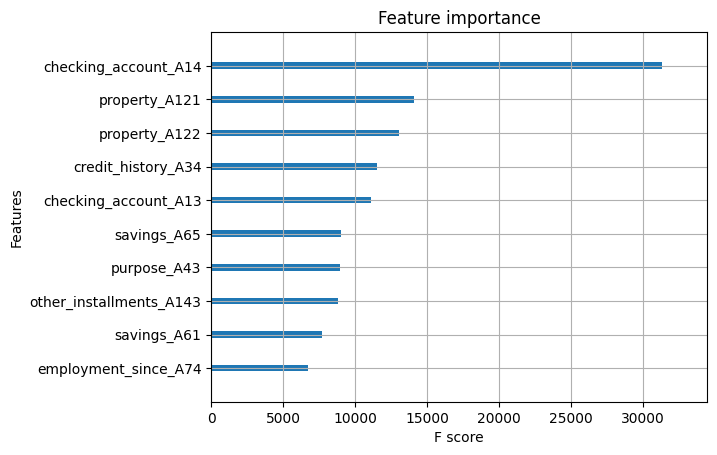

In [20]:
xgb.plot_importance(xgc, importance_type="gain", max_num_features=10, show_values=False);

Based on the above we see that the top three features driving the predictions of the model are:

* checking_account_A14 - lack of a checking account
* credit_history_A34 - critical account / has credits outside of the bank
* property_A121 - real estate

We could also look at the other importance metrics, just for completeness.

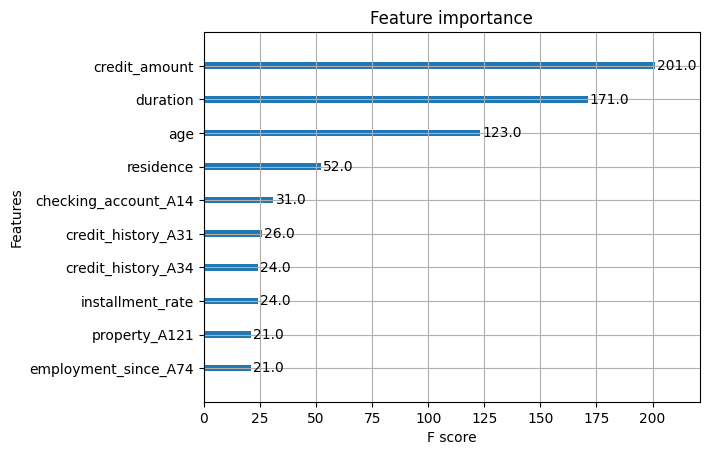

In [21]:
xgb.plot_importance(xgc, importance_type="weight", max_num_features=10);

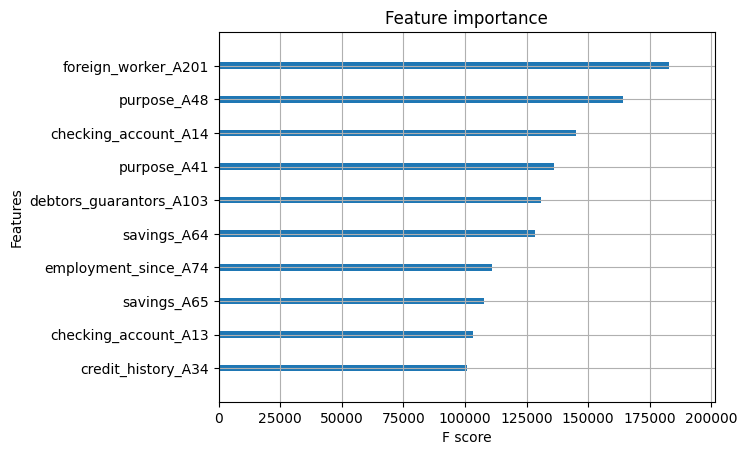

In [22]:
xgb.plot_importance(xgc, importance_type="cover", max_num_features=10, show_values=False);

ELI5 is another popular libarary for model explainability. This package is used to debug machine learning classifiers and explain their predictions. 

Unlike XGBoost, which is confined to explaining its own models only, ELI5 provides support for other frameworks like *scikit-learn*, *Keras*, *LightGBM* and others. It can also explain black-box models (i.e. Neural Networks) using [LIME](https://www.dominodatalab.com/blog/explaining-black-box-models-using-attribute-importance-pdps-and-lime).

First, ELI5 also provides a way of calculating the feature importance. Let's test it and make sure it agrees with the original XGBoost calculation (based on gain).

In [23]:
eli5.show_weights(xgc)

Weight,Feature
0.1064,checking_account_A14
0.0479,property_A121
0.0443,property_A122
0.0392,credit_history_A34
0.0376,checking_account_A13
0.0306,savings_A65
0.0305,purpose_A43
0.0300,other_installments_A143
0.0261,savings_A61
0.0229,employment_since_A74


A more interesting function is `show_predictions`, which returns an explanation of the decision behind individual predictions. In other words, we can see what features drove the model to predict one outcome or the other.

Feel free to experiment with the code below, changing the `id` value and observing what features the model uses to calculate its prediction, and if the prediction agrees with the actual value. The `id` variable represents an observation number from the test dataset.

In [24]:
id = 3 # <- change this to see results for different observations  

print("Actual Label: %s" % actuals.iloc[id])
print("Predicted: %s" % pred_class[id])
eli5.show_prediction(xgc, df_test_X.iloc[id], 
                     feature_names=list(df_test_X.columns),
                     show_feature_values=True)


Actual Label: 1
Predicted: 1


This concludes the model training notebook demo.

In [25]:
# Set some default values
column_names_all = ['duration', 'credit_amount', 'installment_rate', 'residence', 'age', 'credits', 'dependents', 'checking_account_A11', 'checking_account_A12', 'checking_account_A13', 'checking_account_A14', 'credit_history_A30', 'credit_history_A31',
                    'credit_history_A32', 'credit_history_A33', 'credit_history_A34', 'purpose_A40', 'purpose_A41', 'purpose_A410', 'purpose_A42', 'purpose_A43', 'purpose_A44', 'purpose_A45', 'purpose_A46', 'purpose_A48', 'purpose_A49', 'savings_A61', 
                    'savings_A62', 'savings_A63', 'savings_A64', 'savings_A65', 'employment_since_A71', 'employment_since_A72', 'employment_since_A73', 'employment_since_A74', 'employment_since_A75', 'status_A91', 'status_A92', 'status_A93', 'status_A94', 
                    'debtors_guarantors_A101', 'debtors_guarantors_A102', 'debtors_guarantors_A103', 'property_A121', 'property_A122', 'property_A123', 'property_A124', 'other_installments_A141', 'other_installments_A142', 'other_installments_A143', 'housing_A151', 
                    'housing_A152', 'housing_A153', 'job_A171', 'job_A172', 'job_A173', 'job_A174', 'telephone_A191', 'telephone_A192', 'foreign_worker_A201', 'foreign_worker_A202']

sample_data = [[0.4705882352941176, 0.3685484758446132, 0.3333333333333333, 0.3333333333333333, 
                0.2857142857142857, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 
                1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 
                1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 
                1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0]]

In [26]:
df_all = pd.DataFrame(sample_data, columns=column_names_all)

In [27]:
for col in ['checking_account_A11', 'checking_account_A12', 'checking_account_A13', 'checking_account_A14', 
                'credit_history_A30', 'credit_history_A31', 'credit_history_A32', 'credit_history_A33', 
                'credit_history_A34', 'purpose_A40', 'purpose_A41', 'purpose_A410', 'purpose_A42', 'purpose_A43', 
                'purpose_A44', 'purpose_A45', 'purpose_A46', 'purpose_A48', 'purpose_A49', 'savings_A61', 
                'savings_A62', 'savings_A63', 'savings_A64', 'savings_A65', 'employment_since_A71', 
                'employment_since_A72', 'employment_since_A73', 'employment_since_A74', 'employment_since_A75', 
                'status_A91', 'status_A92', 'status_A93', 'status_A94', 'debtors_guarantors_A101', 
                'debtors_guarantors_A102', 'debtors_guarantors_A103', 'property_A121', 'property_A122', 
                'property_A123', 'property_A124', 'other_installments_A141', 'other_installments_A142', 
                'other_installments_A143', 'housing_A151', 'housing_A152', 'housing_A153', 'job_A171', 'job_A172', 
                'job_A173', 'job_A174', 'telephone_A191', 'telephone_A192', 'foreign_worker_A201', 'foreign_worker_A202']:
    df_all[col] = df_all[col].astype('int')


In [28]:
eli5.show_prediction(xgc, df_all.iloc[0], 
                         feature_names=list(df_all.columns),
                         show_feature_values=True)

In [29]:
df_all.iloc[0]

duration               0.470588
credit_amount          0.368548
installment_rate       0.333333
residence              0.333333
age                    0.285714
                         ...   
job_A174               1.000000
telephone_A191         0.000000
telephone_A192         1.000000
foreign_worker_A201    1.000000
foreign_worker_A202    0.000000
Name: 0, Length: 61, dtype: float64

In [30]:
df_all.iloc[0]["checking_account_A14"]

0.0

In [31]:
df_prediction = eli5.explain_prediction_df(xgc, df_all.iloc[0], 
                         feature_names=list(df_all.columns))

In [32]:
df_prediction.head(10).style.background_gradient(cmap = "Greens").hide()

target,feature,weight,value
y,purpose_A41,1.067743,1.000000
y,age,0.788556,0.285714
y,credit_amount,0.523836,0.368548
y,installment_rate,0.151852,0.333333
y,job_A173,0.131838,0.000000
y,telephone_A192,0.129074,1.000000
y,status_A93,0.113385,1.000000
y,employment_since_A72,0.072660,0.000000
y,employment_since_A73,0.071644,1.000000
y,checking_account_A11,0.065276,0.000000
